In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score,precision_recall_curve,roc_curve, auc
from sklearn.preprocessing import StandardScaler,OneHotEncoder,MinMaxScaler
import joblib
import matplotlib.pyplot as plt
import numpy as np

In [2]:
train_data = pd.read_csv("../../data/model_train_data.csv")
test_data = pd.read_csv("../../data/model_test_data.csv")

In [23]:
# train_data.info()

## Standardizing numerical features

In [4]:
numerical_features = ["age",
                      "fico_score",
                      "income_level",
                      "delinquency_status",
                      "max_balance",
                      "avg_balance_last_12months",
                      "account_age_days",
                     "earliest_credit_account_age_days",
                      "days_recent_trade_activity",
                      "new_accounts_opened_last_12months",
                     "number_of_delinquent_accounts",
                      "number_of_defaulted_accounts",
                      "number_of_credit_applications",
                      "debt_to_income_ratio"]

scaler = MinMaxScaler()

train_data[numerical_features] = scaler.fit_transform(train_data[numerical_features])
test_data[numerical_features] = scaler.transform(test_data[numerical_features])

In [24]:
# train_data.describe()

## Seperate Features and Target

In [6]:
target = 'charge_off_status'

X_train = train_data.drop(columns=[target])  
y_train = train_data[target]  

X_test = test_data.drop(columns=[target])  
y_test = test_data[target]  

In [7]:
print(X_train.shape)  
print(y_train.shape) 
print(X_test.shape)   
print(y_test.shape)   

(5398, 22)
(5398,)
(1350, 22)
(1350,)


## One-hot encoding categorical features

In [8]:
categorical_features = ["occupation", "location"]

encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
X_train_encoded = encoder.fit_transform(X_train[categorical_features])
X_test_encoded = encoder.transform(X_test[categorical_features])

encoded_columns = encoder.get_feature_names_out(categorical_features)
X_train_encoded = pd.DataFrame(X_train_encoded, columns=encoded_columns)
X_test_encoded = pd.DataFrame(X_test_encoded, columns=encoded_columns)

X_train = X_train.drop(columns=categorical_features).reset_index(drop=True)
X_test = X_test.drop(columns=categorical_features).reset_index(drop=True)

X_train = pd.concat([X_train, X_train_encoded], axis=1)
X_test = pd.concat([X_test, X_test_encoded], axis=1)

## Training Logistic Regression Model 

In [9]:
log_reg = LogisticRegression(max_iter=500,class_weight='balanced')
log_reg.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=500)

In [10]:
y_pred = log_reg.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("Classification Report:")
print(classification_report(y_test, y_pred))

y_prob = log_reg.predict_proba(X_test)[:, 1]  
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob)}")


Accuracy: 0.8644444444444445
Confusion Matrix:
[[935  79]
 [104 232]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91      1014
           1       0.75      0.69      0.72       336

    accuracy                           0.86      1350
   macro avg       0.82      0.81      0.81      1350
weighted avg       0.86      0.86      0.86      1350

ROC-AUC Score: 0.8334595425941581


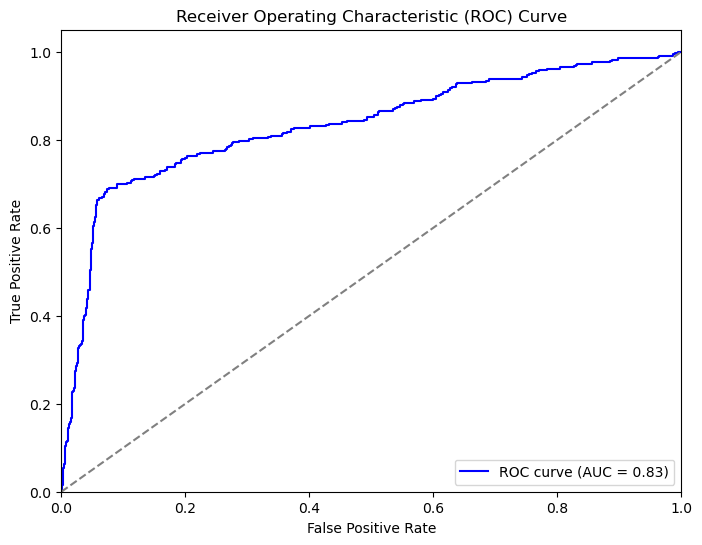

In [11]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--') 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


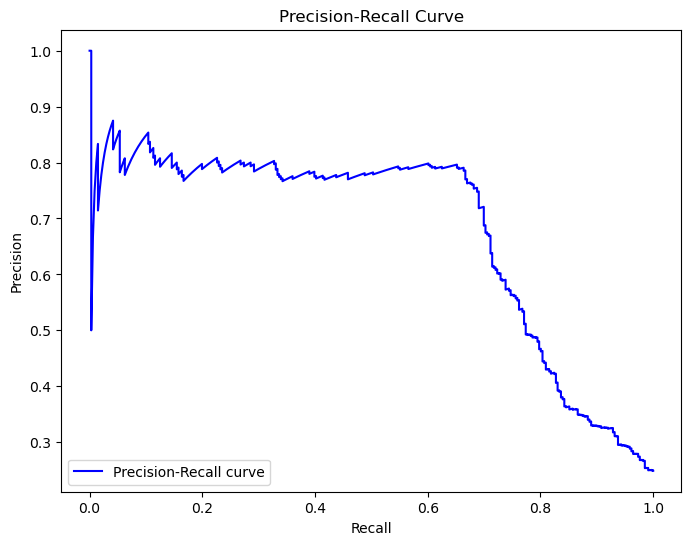

In [25]:
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', label=f'Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()


In [38]:
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm

from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF
X_train_scaled = sm.add_constant(X_train) 
vif_data = pd.DataFrame()
vif_data["Variable"] = X_train_scaled.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_scaled.values, i) for i in range(X_train_scaled.shape[1])]

print(vif_data)

                                   Variable        VIF
0                                     const  76.690288
1                                       age   1.006347
2                              income_level   2.568585
3                                fico_score   3.706883
4                        delinquency_status   5.691496
5             number_of_credit_applications   2.301984
6                      debt_to_income_ratio   1.268974
7                 payment_methods_high_risk   1.469195
8                               max_balance   1.349051
9                 avg_balance_last_12months   1.899727
10            number_of_delinquent_accounts   7.908684
11             number_of_defaulted_accounts   4.436666
12        new_accounts_opened_last_12months   2.704842
13  multiple_applications_short_time_period   1.336644
14               unusual_submission_pattern   2.019285
15  applications_submitted_during_odd_hours   1.176029
16                 watchlist_blacklist_flag   1.020430
17        

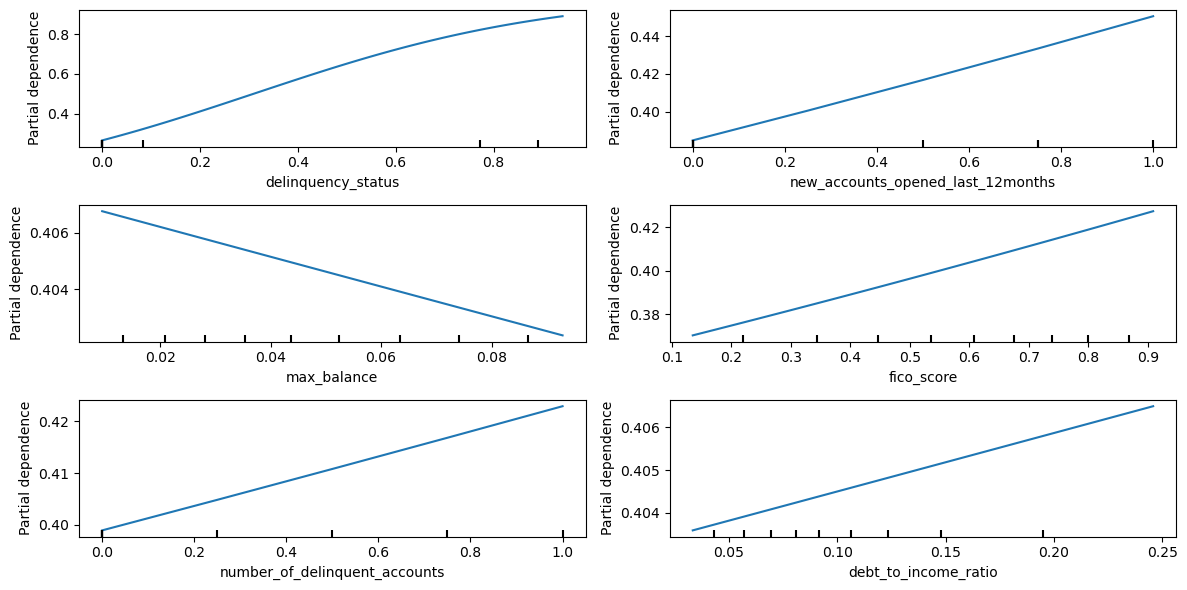

In [46]:
features = ['delinquency_status','new_accounts_opened_last_12months', 'max_balance', 'fico_score','number_of_delinquent_accounts','debt_to_income_ratio']


fig, ax = plt.subplots(nrows=(len(features) + 1) // 2, ncols=2, figsize=(12, 6))  # 2 plots per row
ax = ax.ravel() 


for i, feature in enumerate(features):
    PartialDependenceDisplay.from_estimator(log_reg, X_train, features=[feature], ax=ax[i])
    
plt.tight_layout()
plt.show()

## Saving Model

In [22]:
joblib.dump(log_reg, '../../models/competition_version(initial)/log_reg_model.pkl')

['../models/log_reg_model.pkl']

## Getting Outputs

### 1. Predicting Whether an Account is Likely to Be Charged Off

In [27]:

y_probs = log_reg.predict_proba(X_test)[:, 1]

# Convert probabilities to binary classification based on a threshold (0.5)
y_pred = (y_probs >= 0.5).astype(int)

print(y_pred)

[0 0 0 ... 0 0 0]


### 2. Generating a Credit Risk Score Between 0 and 1000

In [28]:
credit_risk_scores = (y_probs * 1000).astype(int)
print(credit_risk_scores)

[224 297 191 ... 309 393 273]


### 3. Final Results

In [33]:
results = pd.DataFrame({
    'Predicted Probability': y_probs,
    'Predicted Risk Score': credit_risk_scores,
    'Predicted Class': y_pred
})
print(results.head())

   Predicted Probability  Predicted Risk Score  Predicted Class
0               0.224461                   224                0
1               0.297941                   297                0
2               0.191243                   191                0
3               0.356927                   356                0
4               0.250449                   250                0


In [34]:
# Defining the risk level categories based on the 'Predicted Risk Score'
conditions = [
    (results['Predicted Risk Score'] <= 200),
    (results['Predicted Risk Score'] > 200) & (results['Predicted Risk Score'] <= 500),
    (results['Predicted Risk Score'] > 500) & (results['Predicted Risk Score'] <= 800),
    (results['Predicted Risk Score'] > 800)
]
risk_levels = ['Low risk', 'Medium risk', 'High risk', 'Very high risk']

results['Risk Level'] = np.select(conditions, risk_levels, default='Unknown')

print(results.head())

   Predicted Probability  Predicted Risk Score  Predicted Class   Risk Level
0               0.224461                   224                0  Medium risk
1               0.297941                   297                0  Medium risk
2               0.191243                   191                0     Low risk
3               0.356927                   356                0  Medium risk
4               0.250449                   250                0  Medium risk
